# Wildfire Planning Effectiveness Score
Wildfires, exacerbated by climate change, are a growing planning and policy challenge worldwide, particularly in California. In this study, we focused on data analysis and visualization of the wildfire planning effectiveness score of 58 CA counties' the General Plans (GP), Hazard Mitigation Plans (HMP), and Community Wildfire Protection Plans (CWPP) to examine the effectiveness of local mitigation efforts in California's 58 counties.

#### Chendi Zhang
#### Date: 2024/02/23
---
#### Directory
##### 0. Library
##### 1. Data Exploration and Dataset Cleaning
##### 2. Dataframe Merging
##### 3. Mapping
##### 4. Regression

## 0. Library
The libraries we need to install are [Contextily](https://contextily.readthedocs.io/en/latest/) for visualization and [Pysal](https://pysal.org/explore/) for calculating natural breaks.

In [1]:
# Installations
!pip3 install contextily

In [2]:
!pip install pysal

  Using cached pysal-24.1-py3-none-any.whl.metadata (16 kB)
  Using cached access-1.1.9-py3-none-any.whl.metadata (2.4 kB)
  Using cached inequality-1.0.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached pointpats-2.4.0-py3-none-any.whl.metadata (4.5 kB)
  Using cached segregation-2.5-py3-none-any.whl.metadata (2.2 kB)
  Using cached spaghetti-1.7.5.post1-py3-none-any.whl.metadata (12 kB)
  Using cached mgwr-2.2.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached momepy-0.7.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached spglm-1.1.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached spint-1.0.7-py3-none-any.whl
  Using cached spvcm-0.3.0-py3-none-any.whl
  Using cached tobler-0.11.2-py3-none-any.whl.metadata (1.9 kB)
  Using cached spopt-0.6.0-py3-none-any.whl.metadata (10 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl (11 kB)
  Using cached PuLP-2.8.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached rasterstats-0.19.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached s

In [3]:
!pip install matplotlib-scalebar

  Using cached matplotlib_scalebar-0.8.1-py2.py3-none-any.whl.metadata (13 kB)
Using cached matplotlib_scalebar-0.8.1-py2.py3-none-any.whl (17 kB)


In [4]:
pip install mapclassify

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install matplotlib-scalebar

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install Cartopy

  Using cached Cartopy-0.22.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
Using cached Cartopy-0.22.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.9 MB)
Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Import Libraries
import matplotlib.pyplot as plt                    # Creating static, interactive, and animated visualizations in Python.
import contextily as ctx                           # Adding basemaps to geospatial plots.
import pandas as pd                                # Data manipulation, cleaning, and analysis.
import numpy as np                                 # Mathematical operations on arrays and matrices
import geopandas as gpd                            # Managing and visualizing geospatial data.
from matplotlib_scalebar.scalebar import ScaleBar  # Add a scale bar to a plot created with Matplotlib
from matplotlib.colors import ListedColormap       # Customizing color schemes for plots and charts.
import mapclassify                                 # Classify numerical data into distinct categories for thematic geographic mapping
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
import cartopy.crs as ccrs  # Ensure Cartopy is installed

## 1. Data Exploration and Dataset Cleaning
The first step is to find the county shapefile or GeoJSON files. These files contain the geometry data needed for mapping. The county shapefile is sourced from [TIGER/Line](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html) >> [FTP Archive](https://www2.census.gov/geo/tiger/TIGER2023/)>> [COUNTY](https://www2.census.gov/geo/tiger/TIGER2023/COUNTY/)

Let's first take a look at the county dataset.

### County Dataframe

In [8]:
# Import dataset
gdf = gpd.read_file('Data/tl_2023_us_county/tl_2023_us_county.shp') 
pd.set_option('display.max_columns', None) # Display the full columns
print(gdf.shape) # Look at the shape of the dataframe
gdf.head(2)

(3235, 19)


,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."


#### Subset the dataframe
We only need the data of California counties, where the column 'STATEFP' is 06. Thus, we should filter out those rows.

In [9]:
# Filter the rows which "STATEFP" is "06"
CA = gdf[gdf['STATEFP'] == '06']
CA.shape

(58, 19)

After filtering out other rows, the dataset only has 58 counties remaining. 

Then we subset the columns. The "Name" and "geometry" are the only two columns we need.

In [10]:
# Subset columns
CA_small = CA[['NAME', 'geometry']]
CA_small['NAME'] = CA_small['NAME'].str.upper() # Turn the values in column 'Name' to Capital for dataframe merging. 

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Wildfire Planning Effectiveness Dataframe

In [11]:
# Import Alignment Score Ranking dataset
df = pd.read_csv('Data/58counties_240215_all_01sav.csv')
df.head(2)

,CASE_LBL,RPL_THEMES,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,GP_YEAR,CWPP_YEAR,HMP_YEAR,GTheme1,GTheme2,GTheme3,GTheme4,GThemeTIME,GOVERALL,WFA_SUM,WFA_GP,WFA_CWPP,WFA_HMP,WSVI_SUM,WSVI_GP,WSVI_CWPP,WSVI_HMP,GP_TOTAL_P,CWPP_TOTAL_P,HMP_TOTAL_P,THREEPLANS_TOTAL,FIPS_ID,LU_SUM,CIR_SUM,HS_SUM,CSV_SUM,OS_SUM,SFT_SUM,EJ_SUM,K_9.1,GP_TOTAL,CTX_SUM,CLB_SUM,FR_SUM,SI_SUM,STIM_SUM,ME_SUM,VP_SUM,OA_SUM,CWPP_TOTAL,A_SUM,B_SUM,C_SUM,D_SUM,E_SUM,F_SUM,K_7.1_A,HMP_TOTAL,WFIR_RISKS,MEAN_WHP,ExpectedAnnualHUExposed,ExpectedAnnualRelativeHURisk,WHPContinuousMean,WHPClassMean
0,ALAMEDA_01,0.2807,0.1053,0.0702,0.8596,0.8772,2012,2015,2021,3,5,3,3,3,3,0.59,0.45,0.84,0.48,0.32,0.28,0.39,0.28,0.62,0.79,0.79,0.73,1,3,3,6,4,0,19.0,1.5,2,38.5,8,5,5,5,14.05,5,3,4,49.05,8.98,13,9,8,7,2,1,48.98,96.181992,218,133.36,6396,838,2.3173
1,ALPINE_02,0.3509,0.3509,0.5263,0.4912,0.1930,2017,2018,2018,4,4,2,5,5,4,0.62,0.44,0.87,0.56,0.08,0.24,0.00,0.00,0.56,0.84,0.76,0.72,3,2,3,7,6,0,14.0,1.5,1,34.5,7,5,6,6,15.38,7,0,6,52.38,9.98,10,10,8,7,2,0,46.98,81.641744,511,1.37,76,909,3.0904


#### Clean the dataframe

In [12]:
CA_small = CA_small.sort_values(by='NAME',ascending = True)

In [13]:
df2 = df
df['NAME'] = CA_small['NAME'].values
df.head(5)

,CASE_LBL,RPL_THEMES,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,GP_YEAR,CWPP_YEAR,HMP_YEAR,GTheme1,GTheme2,GTheme3,GTheme4,GThemeTIME,GOVERALL,WFA_SUM,WFA_GP,WFA_CWPP,WFA_HMP,WSVI_SUM,WSVI_GP,WSVI_CWPP,WSVI_HMP,GP_TOTAL_P,CWPP_TOTAL_P,HMP_TOTAL_P,THREEPLANS_TOTAL,FIPS_ID,LU_SUM,CIR_SUM,HS_SUM,CSV_SUM,OS_SUM,SFT_SUM,EJ_SUM,K_9.1,GP_TOTAL,CTX_SUM,CLB_SUM,FR_SUM,SI_SUM,STIM_SUM,ME_SUM,VP_SUM,OA_SUM,CWPP_TOTAL,A_SUM,B_SUM,C_SUM,D_SUM,E_SUM,F_SUM,K_7.1_A,HMP_TOTAL,WFIR_RISKS,MEAN_WHP,ExpectedAnnualHUExposed,ExpectedAnnualRelativeHURisk,WHPContinuousMean,WHPClassMean,NAME
0,ALAMEDA_01,0.2807,0.1053,0.0702,0.8596,0.8772,2012,2015,2021,3,5,3,3,3,3,0.59,0.45,0.84,0.48,0.32,0.28,0.39,0.28,0.62,0.79,0.79,0.73,1,3,3,6,4,0,19.0,1.5,2,38.5,8,5,5,5,14.05,5,3,4,49.05,8.98,13,9,8,7,2,1,48.98,96.181992,218,133.36,6396,838,2.3173,ALAMEDA
1,ALPINE_02,0.3509,0.3509,0.5263,0.4912,0.1930,2017,2018,2018,4,4,2,5,5,4,0.62,0.44,0.87,0.56,0.08,0.24,0.00,0.00,0.56,0.84,0.76,0.72,3,2,3,7,6,0,14.0,1.5,1,34.5,7,5,6,6,15.38,7,0,6,52.38,9.98,10,10,8,7,2,0,46.98,81.641744,511,1.37,76,909,3.0904,ALPINE
2,AMADOR_03,0.2281,0.1930,0.1579,0.1754,0.6667,2016,2004,2020,5,5,2,1,3,3,0.57,0.43,0.57,0.71,0.23,0.15,0.00,0.56,0.65,0.60,0.95,0.73,5,3,4,4,6,1,19.5,1.5,1,40.0,6,4.5,5,4,12.55,3,0,2,37.05,9.98,14,14,9,8,2,2,58.98,97.391028,1602,62.51,4134,2367,3.5750,AMADOR
3,BUTTE_04,0.5965,0.5965,0.4386,0.2456,0.8596,2023,2022,2019,5,3,4,5,5,5,0.63,0.54,0.64,0.70,0.44,0.78,0.00,0.56,0.77,0.56,0.90,0.74,7,4,4,5,4,2,20.5,6.0,2,47.5,5,2.5,4.5,4,12.73,3,0,3,34.73,8.98,14,12,10,8,1,2,55.98,98.790964,773,157.49,9255,1769,3.0979,BUTTE
4,CALAVERAS_05,0.1053,0.4211,0.3509,0.0526,0.0000,2019,2020,2021,5,4,5,5,5,5,0.65,0.53,0.86,0.55,0.54,0.51,0.56,0.56,0.70,0.89,0.85,0.81,9,4,4,5,7,1,19.0,2.5,1,43.5,8,5,6,5,16.05,7,4,4,55.05,9.98,13,10,9,7,2,2,52.98,99.427299,2242,115.12,7760,3022,3.8235,CALAVERAS


## Dataframe Merging
By merging two dataframes, the Alignment Score Rank dataframe can have geometry data for mapping.  

In [14]:
# Perform a 'left' merging based on 'NAME' column    # Return all rows from the left dataset and the matched rows from the right dataset
df3 = pd.merge(df, CA_small, on='NAME', how='left')
df3.head(5)

,CASE_LBL,RPL_THEMES,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,GP_YEAR,CWPP_YEAR,HMP_YEAR,GTheme1,GTheme2,GTheme3,GTheme4,GThemeTIME,GOVERALL,WFA_SUM,WFA_GP,WFA_CWPP,WFA_HMP,WSVI_SUM,WSVI_GP,WSVI_CWPP,WSVI_HMP,GP_TOTAL_P,CWPP_TOTAL_P,HMP_TOTAL_P,THREEPLANS_TOTAL,FIPS_ID,LU_SUM,CIR_SUM,HS_SUM,CSV_SUM,OS_SUM,SFT_SUM,EJ_SUM,K_9.1,GP_TOTAL,CTX_SUM,CLB_SUM,FR_SUM,SI_SUM,STIM_SUM,ME_SUM,VP_SUM,OA_SUM,CWPP_TOTAL,A_SUM,B_SUM,C_SUM,D_SUM,E_SUM,F_SUM,K_7.1_A,HMP_TOTAL,WFIR_RISKS,MEAN_WHP,ExpectedAnnualHUExposed,ExpectedAnnualRelativeHURisk,WHPContinuousMean,WHPClassMean,NAME,geometry
0,ALAMEDA_01,0.2807,0.1053,0.0702,0.8596,0.8772,2012,2015,2021,3,5,3,3,3,3,0.59,0.45,0.84,0.48,0.32,0.28,0.39,0.28,0.62,0.79,0.79,0.73,1,3,3,6,4,0,19.0,1.5,2,38.5,8,5,5,5,14.05,5,3,4,49.05,8.98,13,9,8,7,2,1,48.98,96.181992,218,133.36,6396,838,2.3173,ALAMEDA,"POLYGON ((-122.37312 37.88388, -122.37114 37.8..."
1,ALPINE_02,0.3509,0.3509,0.5263,0.4912,0.1930,2017,2018,2018,4,4,2,5,5,4,0.62,0.44,0.87,0.56,0.08,0.24,0.00,0.00,0.56,0.84,0.76,0.72,3,2,3,7,6,0,14.0,1.5,1,34.5,7,5,6,6,15.38,7,0,6,52.38,9.98,10,10,8,7,2,0,46.98,81.641744,511,1.37,76,909,3.0904,ALPINE,"POLYGON ((-120.07333 38.70109, -120.07324 38.7..."
2,AMADOR_03,0.2281,0.1930,0.1579,0.1754,0.6667,2016,2004,2020,5,5,2,1,3,3,0.57,0.43,0.57,0.71,0.23,0.15,0.00,0.56,0.65,0.60,0.95,0.73,5,3,4,4,6,1,19.5,1.5,1,40.0,6,4.5,5,4,12.55,3,0,2,37.05,9.98,14,14,9,8,2,2,58.98,97.391028,1602,62.51,4134,2367,3.5750,AMADOR,"POLYGON ((-121.02771 38.50011, -121.02770 38.5..."
3,BUTTE_04,0.5965,0.5965,0.4386,0.2456,0.8596,2023,2022,2019,5,3,4,5,5,5,0.63,0.54,0.64,0.70,0.44,0.78,0.00,0.56,0.77,0.56,0.90,0.74,7,4,4,5,4,2,20.5,6.0,2,47.5,5,2.5,4.5,4,12.73,3,0,3,34.73,8.98,14,12,10,8,1,2,55.98,98.790964,773,157.49,9255,1769,3.0979,BUTTE,"POLYGON ((-122.06943 39.84053, -122.06874 39.8..."
4,CALAVERAS_05,0.1053,0.4211,0.3509,0.0526,0.0000,2019,2020,2021,5,4,5,5,5,5,0.65,0.53,0.86,0.55,0.54,0.51,0.56,0.56,0.70,0.89,0.85,0.81,9,4,4,5,7,1,19.0,2.5,1,43.5,8,5,6,5,16.05,7,4,4,55.05,9.98,13,10,9,7,2,2,52.98,99.427299,2242,115.12,7760,3022,3.8235,CALAVERAS,"POLYGON ((-120.63179 38.34603, -120.63066 38.3..."


In [15]:
df3.shape

(58, 62)

The dataframe becomes a normal dataframe due to the left merge. Thus, we need to convert it back into a GeoDataFrame.

In [16]:
# Convert dataframe to geodataframe
gdf2 = gpd.GeoDataFrame(df3, geometry='geometry')
gdf2.crs # Check the crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [17]:
# Export the GeoDataFrame as a shapefile
gdf2.to_file('Data/Merge.shp')
gdf2.to_csv('Data/Merge.csv')

/tmp/ipykernel_313/3671561931.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf2.to_file('Data/Merge.shp')


In [18]:
TEST1 = pd.read_csv('Data/Merge.csv')
TEST1.head(2)
TEST1.drop('Unnamed: 0', axis=1, inplace=True)
TEST1.head(2)

,CASE_LBL,RPL_THEMES,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,GP_YEAR,CWPP_YEAR,HMP_YEAR,GTheme1,GTheme2,GTheme3,GTheme4,GThemeTIME,GOVERALL,WFA_SUM,WFA_GP,WFA_CWPP,WFA_HMP,WSVI_SUM,WSVI_GP,WSVI_CWPP,WSVI_HMP,GP_TOTAL_P,CWPP_TOTAL_P,HMP_TOTAL_P,THREEPLANS_TOTAL,FIPS_ID,LU_SUM,CIR_SUM,HS_SUM,CSV_SUM,OS_SUM,SFT_SUM,EJ_SUM,K_9.1,GP_TOTAL,CTX_SUM,CLB_SUM,FR_SUM,SI_SUM,STIM_SUM,ME_SUM,VP_SUM,OA_SUM,CWPP_TOTAL,A_SUM,B_SUM,C_SUM,D_SUM,E_SUM,F_SUM,K_7.1_A,HMP_TOTAL,WFIR_RISKS,MEAN_WHP,ExpectedAnnualHUExposed,ExpectedAnnualRelativeHURisk,WHPContinuousMean,WHPClassMean,NAME,geometry
0,ALAMEDA_01,0.2807,0.1053,0.0702,0.8596,0.8772,2012,2015,2021,3,5,3,3,3,3,0.59,0.45,0.84,0.48,0.32,0.28,0.39,0.28,0.62,0.79,0.79,0.73,1,3,3,6,4,0,19.0,1.5,2,38.5,8,5,5,5,14.05,5,3,4,49.05,8.98,13,9,8,7,2,1,48.98,96.181992,218,133.36,6396,838,2.3173,ALAMEDA,"POLYGON ((-122.373121 37.883884, -122.371142 3..."
1,ALPINE_02,0.3509,0.3509,0.5263,0.4912,0.1930,2017,2018,2018,4,4,2,5,5,4,0.62,0.44,0.87,0.56,0.08,0.24,0.00,0.00,0.56,0.84,0.76,0.72,3,2,3,7,6,0,14.0,1.5,1,34.5,7,5,6,6,15.38,7,0,6,52.38,9.98,10,10,8,7,2,0,46.98,81.641744,511,1.37,76,909,3.0904,ALPINE,"POLYGON ((-120.073331 38.70109, -120.073236 38..."


In [19]:
TEST2 = gpd.read_file('Data/Merge.shp') 
pd.set_option('display.max_columns', None) # Display the full columns
print(TEST2.shape) # Look at the shape of the dataframe
TEST2.head(2)

(58, 62)


,CASE_LBL,RPL_THEMES,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,GP_YEAR,CWPP_YEAR,HMP_YEAR,GTheme1,GTheme2,GTheme3,GTheme4,GThemeTIME,GOVERALL,WFA_SUM,WFA_GP,WFA_CWPP,WFA_HMP,WSVI_SUM,WSVI_GP,WSVI_CWPP,WSVI_HMP,GP_TOTAL_P,CWPP_TOTAL,HMP_TOTAL_,THREEPLANS,FIPS_ID,LU_SUM,CIR_SUM,HS_SUM,CSV_SUM,OS_SUM,SFT_SUM,EJ_SUM,K_9.1,GP_TOTAL,CTX_SUM,CLB_SUM,FR_SUM,SI_SUM,STIM_SUM,ME_SUM,VP_SUM,OA_SUM,CWPP_TOT_1,A_SUM,B_SUM,C_SUM,D_SUM,E_SUM,F_SUM,K_7.1_A,HMP_TOTAL,WFIR_RISKS,MEAN_WHP,ExpectedAn,Expected_1,WHPContinu,WHPClassMe,NAME,geometry
0,ALAMEDA_01,0.2807,0.1053,0.0702,0.8596,0.8772,2012,2015,2021,3,5,3,3,3,3,0.59,0.45,0.84,0.48,0.32,0.28,0.39,0.28,0.62,0.79,0.79,0.73,1,3,3,6,4,0,19.0,1.5,2,38.5,8,5,5,5,14.05,5,3,4,49.05,8.98,13,9,8,7,2,1,48.98,96.181992,218,133.36,6396,838,2.3173,ALAMEDA,"POLYGON ((-122.37312 37.88388, -122.37114 37.8..."
1,ALPINE_02,0.3509,0.3509,0.5263,0.4912,0.1930,2017,2018,2018,4,4,2,5,5,4,0.62,0.44,0.87,0.56,0.08,0.24,0.00,0.00,0.56,0.84,0.76,0.72,3,2,3,7,6,0,14.0,1.5,1,34.5,7,5,6,6,15.38,7,0,6,52.38,9.98,10,10,8,7,2,0,46.98,81.641744,511,1.37,76,909,3.0904,ALPINE,"POLYGON ((-120.07333 38.70109, -120.07324 38.7..."


## Mapping
The final step is mapping based on the ranking data and the geometry of each county. We use [matplotlib.colormaps](https://matplotlib.org/stable/users/explain/colors/colormaps.html) for color mapping, and [Contextily](https://contextily.readthedocs.io/en/latest/) to add a basemap to the axes. We can also use colors of your choice. 

### Color Mapping with Contextily

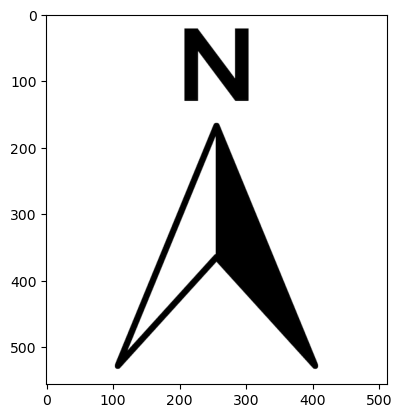

In [20]:
# Map the north arrow
NorthArrow = plt.imread('Data/N.png') # 'plt.imread' loads the image as an array into the variable NorthArrow. 
plt.imshow(NorthArrow) # displays the image array (NorthArrow) on a plot

In [21]:
# Reproject the geometries to a projected CRS (EPSG:4269)
gdf2_projected = gdf2.to_crs(epsg=4269)
gdf2_projected.head()

,CASE_LBL,RPL_THEMES,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,GP_YEAR,CWPP_YEAR,HMP_YEAR,GTheme1,GTheme2,GTheme3,GTheme4,GThemeTIME,GOVERALL,WFA_SUM,WFA_GP,WFA_CWPP,WFA_HMP,WSVI_SUM,WSVI_GP,WSVI_CWPP,WSVI_HMP,GP_TOTAL_P,CWPP_TOTAL_P,HMP_TOTAL_P,THREEPLANS_TOTAL,FIPS_ID,LU_SUM,CIR_SUM,HS_SUM,CSV_SUM,OS_SUM,SFT_SUM,EJ_SUM,K_9.1,GP_TOTAL,CTX_SUM,CLB_SUM,FR_SUM,SI_SUM,STIM_SUM,ME_SUM,VP_SUM,OA_SUM,CWPP_TOTAL,A_SUM,B_SUM,C_SUM,D_SUM,E_SUM,F_SUM,K_7.1_A,HMP_TOTAL,WFIR_RISKS,MEAN_WHP,ExpectedAnnualHUExposed,ExpectedAnnualRelativeHURisk,WHPContinuousMean,WHPClassMean,NAME,geometry
0,ALAMEDA_01,0.2807,0.1053,0.0702,0.8596,0.8772,2012,2015,2021,3,5,3,3,3,3,0.59,0.45,0.84,0.48,0.32,0.28,0.39,0.28,0.62,0.79,0.79,0.73,1,3,3,6,4,0,19.0,1.5,2,38.5,8,5,5,5,14.05,5,3,4,49.05,8.98,13,9,8,7,2,1,48.98,96.181992,218,133.36,6396,838,2.3173,ALAMEDA,"POLYGON ((-122.37312 37.88388, -122.37114 37.8..."
1,ALPINE_02,0.3509,0.3509,0.5263,0.4912,0.1930,2017,2018,2018,4,4,2,5,5,4,0.62,0.44,0.87,0.56,0.08,0.24,0.00,0.00,0.56,0.84,0.76,0.72,3,2,3,7,6,0,14.0,1.5,1,34.5,7,5,6,6,15.38,7,0,6,52.38,9.98,10,10,8,7,2,0,46.98,81.641744,511,1.37,76,909,3.0904,ALPINE,"POLYGON ((-120.07333 38.70109, -120.07324 38.7..."
2,AMADOR_03,0.2281,0.1930,0.1579,0.1754,0.6667,2016,2004,2020,5,5,2,1,3,3,0.57,0.43,0.57,0.71,0.23,0.15,0.00,0.56,0.65,0.60,0.95,0.73,5,3,4,4,6,1,19.5,1.5,1,40.0,6,4.5,5,4,12.55,3,0,2,37.05,9.98,14,14,9,8,2,2,58.98,97.391028,1602,62.51,4134,2367,3.5750,AMADOR,"POLYGON ((-121.02771 38.50011, -121.02770 38.5..."
3,BUTTE_04,0.5965,0.5965,0.4386,0.2456,0.8596,2023,2022,2019,5,3,4,5,5,5,0.63,0.54,0.64,0.70,0.44,0.78,0.00,0.56,0.77,0.56,0.90,0.74,7,4,4,5,4,2,20.5,6.0,2,47.5,5,2.5,4.5,4,12.73,3,0,3,34.73,8.98,14,12,10,8,1,2,55.98,98.790964,773,157.49,9255,1769,3.0979,BUTTE,"POLYGON ((-122.06943 39.84053, -122.06874 39.8..."
4,CALAVERAS_05,0.1053,0.4211,0.3509,0.0526,0.0000,2019,2020,2021,5,4,5,5,5,5,0.65,0.53,0.86,0.55,0.54,0.51,0.56,0.56,0.70,0.89,0.85,0.81,9,4,4,5,7,1,19.0,2.5,1,43.5,8,5,6,5,16.05,7,4,4,55.05,9.98,13,10,9,7,2,2,52.98,99.427299,2242,115.12,7760,3022,3.8235,CALAVERAS,"POLYGON ((-120.63179 38.34603, -120.63066 38.3..."


In [22]:
# Calculate centroids in the projected CRS
gdf2_projected['centroid'] = gdf2_projected.geometry.centroid
# Reproject centroids back to geographic CRS
gdf2_projected['centroid'] = gdf2_projected['centroid'].to_crs(epsg=4326)
# Extract latitude and longitude
gdf2['latitude'] = gdf2_projected['centroid'].y
gdf2['longitude'] = gdf2_projected['centroid'].x

/tmp/ipykernel_313/620046510.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf2_projected['centroid'] = gdf2_projected.geometry.centroid


In [23]:
# Reproject to a suitable projected CRS for accurate geometric calculations
gdf2_projected = gdf2.to_crs(epsg=2163)

# Calculate centroids in the projected CRS
gdf2_projected['centroid'] = gdf2_projected.geometry.centroid

# Reproject centroids back to geographic CRS for latitude and longitude
gdf2_projected['centroid'] = gdf2_projected['centroid'].to_crs(epsg=4326)

# Extract latitude and longitude
gdf2['latitude'] = gdf2_projected['centroid'].y
gdf2['longitude'] = gdf2_projected['centroid'].x

# Now, 'latitude' and 'longitude' are correctly calculated
print(gdf2[['CASE_LBL', 'latitude', 'longitude']].head())

       CASE_LBL   latitude   longitude
0    ALAMEDA_01  37.650629 -121.917746
1     ALPINE_02  38.597115 -119.820560
2     AMADOR_03  38.446647 -120.651632
3      BUTTE_04  39.666596 -121.600597
4  CALAVERAS_05  38.204476 -120.554619


### Test the function before define the function

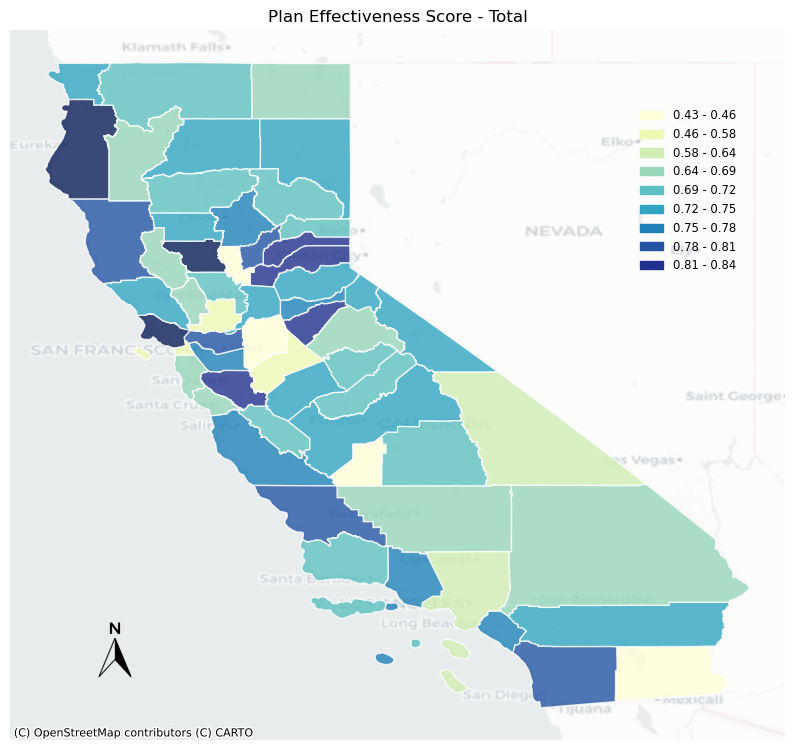

In [52]:
# Classify data
classifier = mapclassify.NaturalBreaks(y=gdf2['THREEPLANS_TOTAL'], k=10)

# Add classified data back to GeoDataFrame
gdf2['THREEPLANS_TOTAL_classified'] = classifier.yb

# Create range descriptions for each class
class_ranges = classifier.bins
class_descriptions = [f"{class_ranges[i]} - {class_ranges[i+1]}" for i in range(len(class_ranges)-1)]

fig, ax = plt.subplots(figsize=(10,10)) # Create a Figure and Axes

# Make the axes not visible
ax.set_axis_off()

# project to 3857 to match the basemap
gdf2.to_crs('EPSG:4269').plot('THREEPLANS_TOTAL_classified',  
                              ax=ax,
                              legend=False,
                              alpha=0.8,
                              cmap='YlGnBu', # Choose the colors you like
                              edgecolor="White",
                              linewidth=1,  # Adjust edge width here
                              categorical=True) # Treat data as categorical

# Create a list of patches for the legend
legend_patches = [mpatches.Patch(color=plt.cm.YlGnBu(i/9), label=f"{class_descriptions[i]}") for i in range(len(class_descriptions))]

# Add the custom legend to the plot
ax.legend(handles=legend_patches, title='\n\n\n', loc='upper right', bbox_to_anchor=(0.95, 1), fontsize='small', title_fontsize='medium',  frameon=False)

# Add north arrow
northarrow = fig.add_axes([0.2,0.2,0.06,0.06]) # Create a New Axes Object on the Figure
                                              # The add_axes method accepts a list [left, bottom, width, height] specifying the rectangle's position and size for a new axes object on a figure. 
northarrow.imshow(NorthArrow)
northarrow.axis('off')
# Assuming 'northarrow' is the Axes object for your north arrow
northarrow.set_visible(True)

valid_geometries_gdf = gdf2.dropna(subset=['geometry'])

for idx, row in valid_geometries_gdf.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(x, y, row['NAME'].title(), fontsize=7, ha='center', va='center', color = 'grey', visible=False)
    
# add a title
ax.set_title('Plan Effectiveness Score - Total')

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs="EPSG:4269", alpha=0.5, visible=True)

fig.savefig(r'EXPORT_240218/Plan Effectiveness Score - Total.jpg', dpi = 300)

In [32]:
# Create a new column with 'WFIR_RISKS' divided by 100
gdf2['WFIR_RISKS_transformed'] = gdf2['WFIR_RISKS'] / 100
gdf2['WHPClassMean_transformed'] = gdf2['WHPClassMean'] * 0.2

In [ ]:
# function
def crime_by_neighborhood(place):
    # code to create the crime map

# list of neighborhoods
neighborhoods = ['Downtown','Korea Town','Boyle Heights', ...]

# call the function with a loop
for neighborhood in neighborhoods:
    crime_by_neighborhood(place=neighborhood)

In [38]:
attribute = ['THREEPLANS_TOTAL',
             'GP_TOTAL_P',
             'CWPP_TOTAL_P',
             'HMP_TOTAL_P',
             'RPL_THEMES',
             'WFIR_RISKS_transformed',
             'WHPClassMean_transformed' ]

# Iterate over each attribute to classify
for attribute in attribute:
    # Apply NaturalBreaks classification to each attribute
    classifier = mapclassify.NaturalBreaks(y=gdf2[attribute], k=10)
    
    # Add classified data back to GeoDataFrame as a new column
    classified_column_name = f"{attribute}_classified"  # Create a new column name for the classified data
    gdf2[classified_column_name] = classifier.yb
    
    # Create range descriptions for each class
    class_ranges = classifier.bins
    class_descriptions = [f"{class_ranges[i]} - {class_ranges[i+1]}" for i in range(len(class_ranges)-1)]

In [65]:
def plot_classified_data(score_type, gdf, title, filename, k=10):
    # Make sure all lines within the function are indented
    classifier = mapclassify.NaturalBreaks(y=gdf[score_type], k=k)
    classified_column_name = f"{score_type}_classified"
    gdf[classified_column_name] = classifier.yb

    class_ranges = classifier.bins
    class_descriptions = [f"{class_ranges[i]} - {class_ranges[i+1]}" for i in range(len(class_ranges)-1)]

    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_axis_off()

    gdf.to_crs('EPSG:4269').plot(classified_column_name, ax=ax, legend=False, alpha=0.8,
                                 cmap='YlGnBu', edgecolor="White", linewidth=1, categorical=True)

    legend_patches = [mpatches.Patch(color=plt.cm.YlGnBu(i/9), label=f"{class_descriptions[i]}") for i in range(len(class_descriptions))]
    ax.legend(handles=legend_patches, title='\n\n\n', loc='upper right', bbox_to_anchor=(0.95, 1),
              fontsize='small', title_fontsize='medium', frameon=False)

    northarrow = fig.add_axes([0.2, 0.2, 0.06, 0.06])  # Correct indentation
    # Make sure NorthArrow is defined or loaded before using
    northarrow.imshow(NorthArrow)
    northarrow.axis('off')
    northarrow.set_visible(True)

    # add a title
    ax.set_title(filename)

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs="EPSG:4269", alpha=0.5)

    # Correct the filename path if necessary
    fig.savefig(filename, dpi=300)
    plt.show()  # Display the figure

In [63]:
score_types = ['THREEPLANS_TOTAL',
             'GP_TOTAL_P',
             'CWPP_TOTAL_P',
             'HMP_TOTAL_P',
             'RPL_THEMES',
             'WFIR_RISKS_transformed',
             'WHPClassMean_transformed' ]

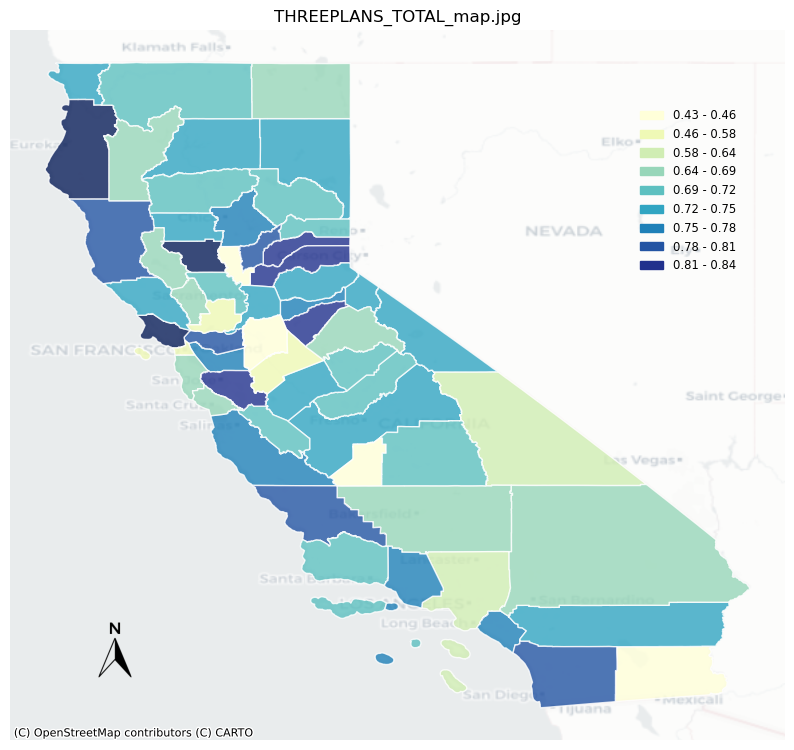

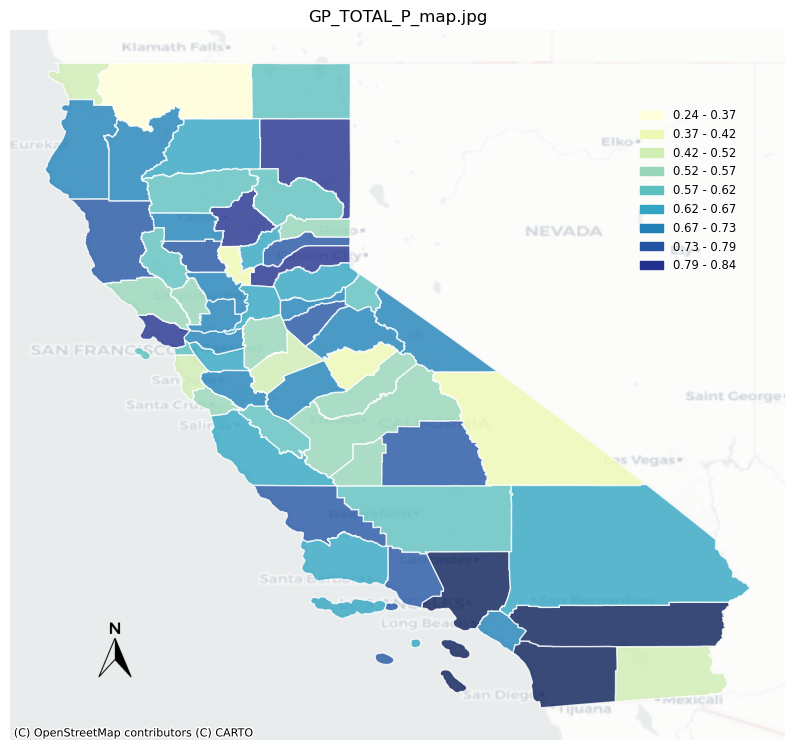

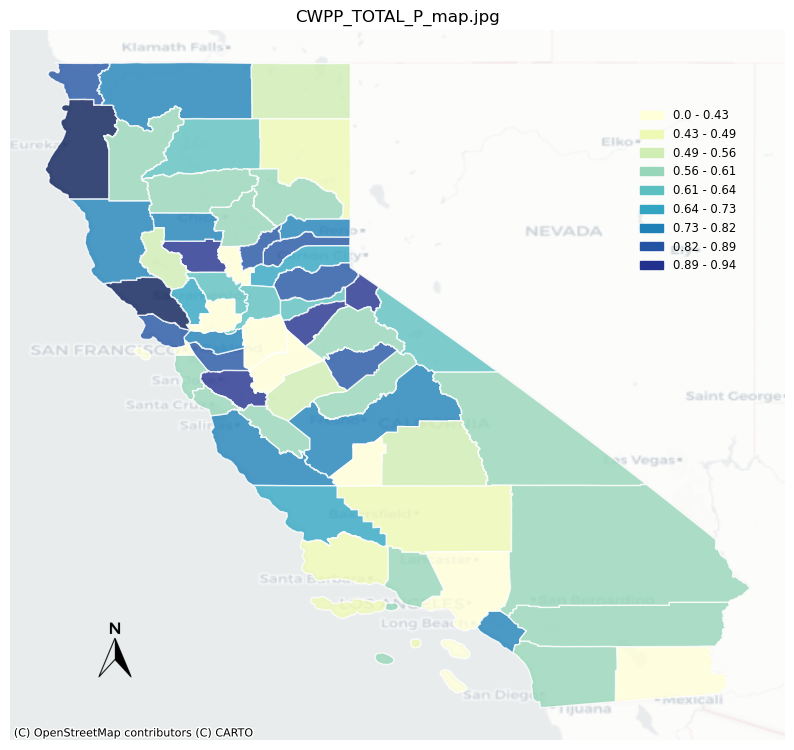

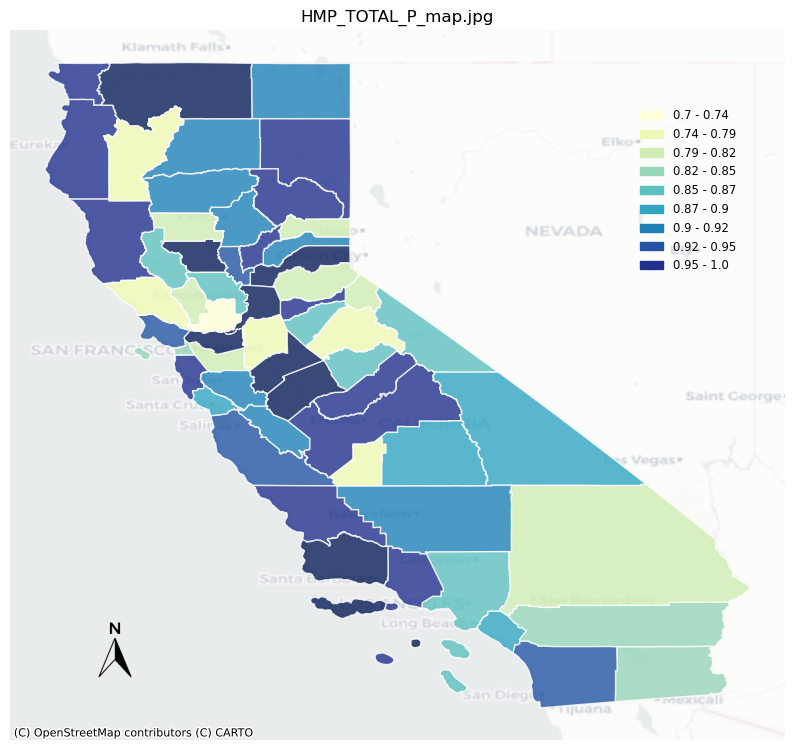

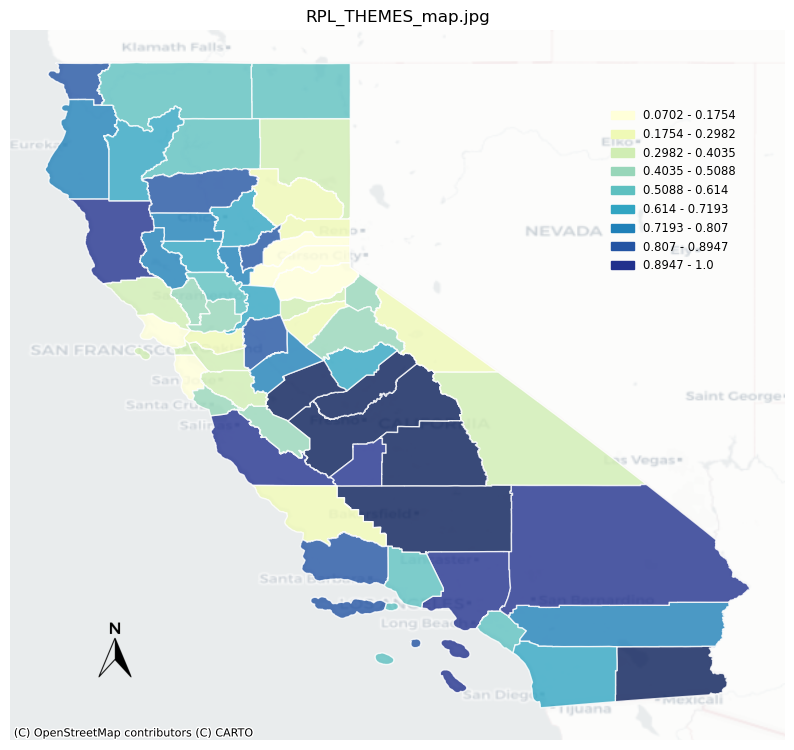

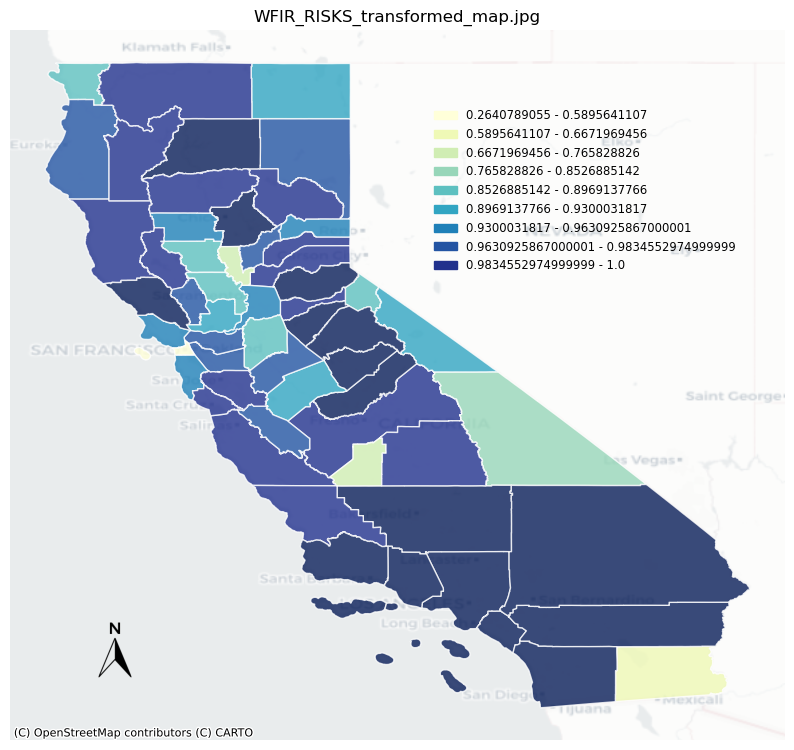

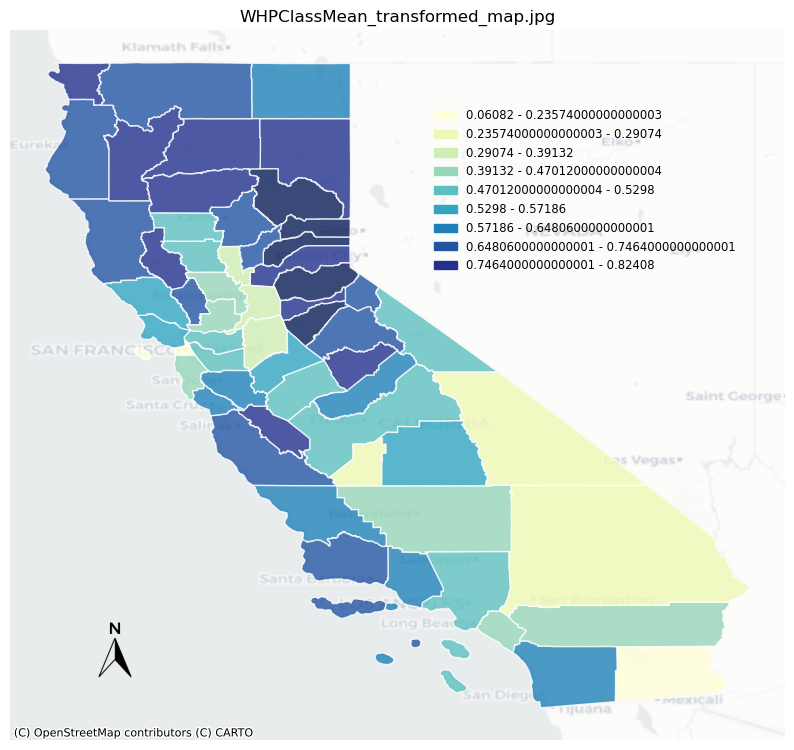

In [66]:
for score_type in score_types:
    plot_classified_data(score_type=score_type, gdf=gdf2, title=f"{score_type} Classified Map", filename=f"{score_type}_map.jpg", k=10)

## Map overlay

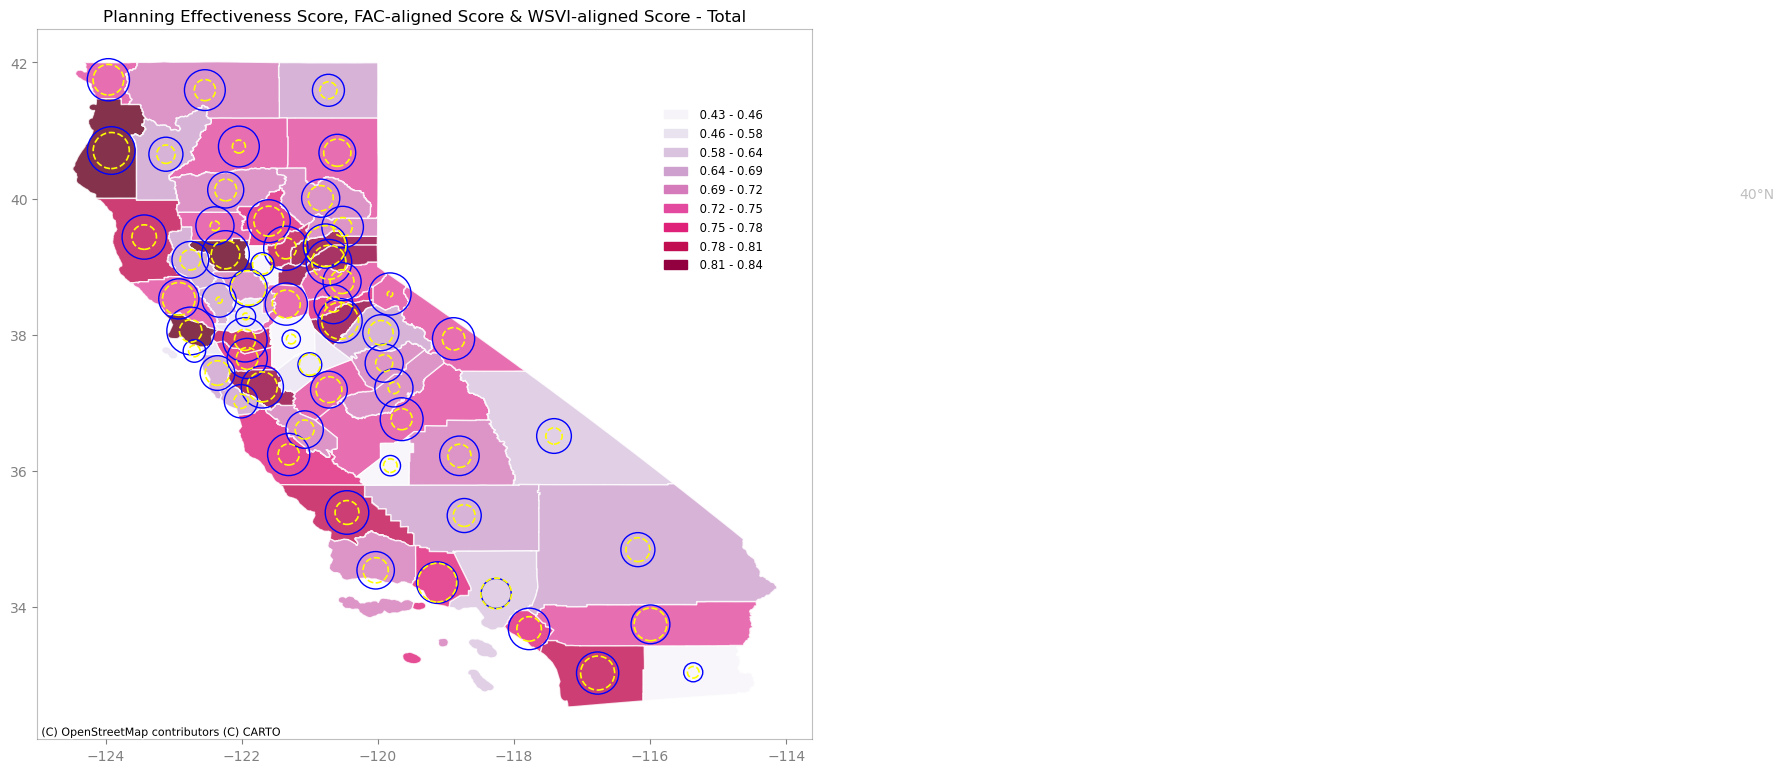

In [67]:
# Classify data
classifier = mapclassify.NaturalBreaks(y=gdf2['THREEPLANS_TOTAL'], k=10)

# Add classified data back to GeoDataFrame
gdf2['THREEPLANS_TOTAL_classified'] = classifier.yb

# Create range descriptions for each class
class_ranges = classifier.bins
class_descriptions = [f"{class_ranges[i]} - {class_ranges[i+1]}" for i in range(len(class_ranges)-1)]

fig, ax = plt.subplots(figsize=(10,10)) # Create a Figure and Axes

# Set edge color and transparency of the map frame
ax.spines['top'].set_color('grey')
ax.spines['top'].set_alpha(0.5)  # Adjust alpha for transparency
ax.spines['bottom'].set_color('grey')
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_color('grey')
ax.spines['left'].set_alpha(0.5)
ax.spines['right'].set_color('grey')
ax.spines['right'].set_alpha(0.5)

## Assuming 'ax' is your Matplotlib Axes object
# Set the color and alpha of the tick labels directly

ax.tick_params(colors='grey', labelsize='medium')  # Adjust tick colors and size

# If working with a GeoPandas plot that doesn't show lat/long labels by default
# and you wish to add custom annotations or a grid, consider using annotations or drawing lines manually
# Note: This approach doesn't require transforming coordinates

# Example: Manually adding text annotations for lat/long (simplified, illustrative purposes only)
ax.text(-100, 40, '40°N', color='grey', alpha=0.5)  # Example annotation

# This approach requires knowing the positions where you want these annotations to appear,
# which might not be directly applicable for dynamically adding graticules across the entire map extent.

# project to 3857 to match the basemap
gdf2.to_crs('EPSG:4269').plot('THREEPLANS_TOTAL_classified', 
                              ax=ax, 
                              legend=False,
                              alpha=0.8,
                              cmap='PuRd', # Choose the colors you like
                              edgecolor="White",
                              linewidth=1,  # Adjust edge width here
                              categorical=True) # Treat data as categorical

# Create a list of patches for the legend
legend_patches = [mpatches.Patch(color=plt.cm.PuRd(i/9), label=f" {class_descriptions[i]}") for i in range(len(class_descriptions))]

# Add the custom legend to the plot
ax.legend(handles=legend_patches, title='\n\n\n', loc='upper right', bbox_to_anchor=(0.95, 1), fontsize='small', title_fontsize='medium',  frameon=False)

# Add north arrow
northarrow = fig.add_axes([0.2,0.2,0.06,0.06]) # Create a New Axes Object on the Figure
                                              # The add_axes method accepts a list [left, bottom, width, height] specifying the rectangle's position and size for a new axes object on a figure. 
northarrow.imshow(NorthArrow)
northarrow.axis('off')
# Assuming 'northarrow' is the Axes object for your north arrow
northarrow.set_visible(False)

# Add a basemap
#ctx.add_basemap(ax=ax, zoom=12, source=ctx.providers.CartoDB.Positron) # for more options, see https://contextily.readthedocs.io/en/latest/providers_deepdive.html

# drop the tick labels'
# ax.set_xticks([])
# ax.set_yticks([])

# add a title
ax.set_title('Planning Effectiveness Score, FAC-aligned Score & WSVI-aligned Score - Total')

# Overlay circles on the map
for idx, row in gdf2.iterrows():
    # Calculate the radius of the circle. The 'RPL_THEMES' value is multiplied by 500 to get the diameter,
    # and then divided by 2 to get the radius. Adjust the multiplier as needed for your visualization.
    radius = (row['WFA_SUM']) / 2  # Adjust the multiplication factor as needed

    # Create a Circle patch with the calculated radius and add it to the plot
    circle = Circle((row.geometry.centroid.x, row.geometry.centroid.y), radius, 
                    edgecolor='Blue', facecolor='none', lw=1, linestyle='-')
    ax.add_patch(circle)

# Overlay circles on the map
for idx, row in gdf2.iterrows():
    # Calculate the radius of the circle. The 'RPL_THEMES' value is multiplied by 500 to get the diameter,
    # and then divided by 2 to get the radius. Adjust the multiplier as needed for your visualization.
    radius2 = (row['WSVI_SUM']) / 2  # Adjust the multiplication factor as needed

    # Create a Circle patch with the calculated radius and add it to the plot
    circle2 = Circle((row.geometry.centroid.x, row.geometry.centroid.y), radius2, 
                    edgecolor='Yellow', facecolor='none', lw=1.2, linestyle='--')
    ax.add_patch(circle2)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs="EPSG:4269", alpha=0.5, visible=False)

fig.savefig(r'EXPORT_240218/Planning Effectiveness Score, FAC-aligned Score & WSVI-aligned Score - Total.png', dpi = 300)

# Regression

In [77]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

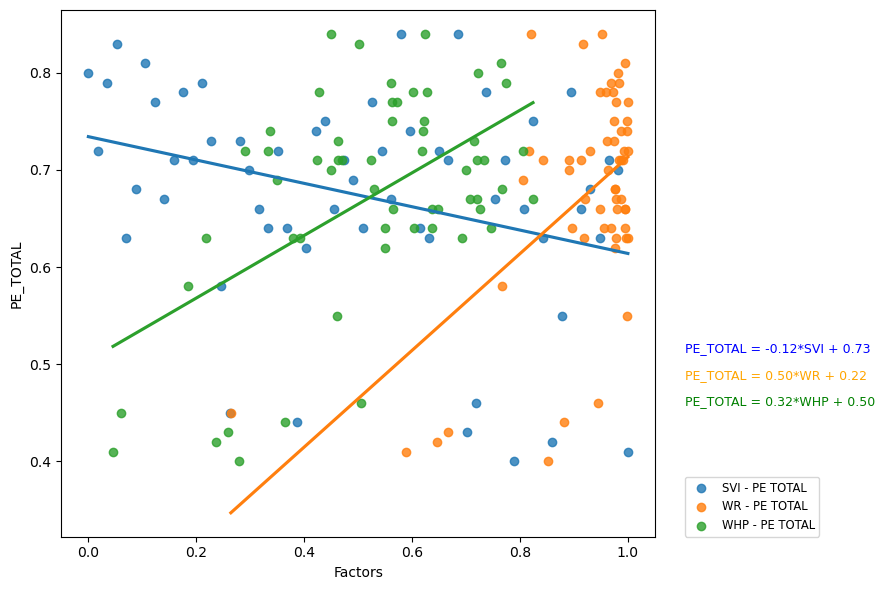

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Create a new column with 'WFIR_RISKS' divided by 100
gdf2['WFIR_RISKS_transformed'] = gdf2['WFIR_RISKS'] / 100
gdf2['WHPClassMean_transformed'] = gdf2['WHPClassMean'] * 0.2

# Create the figure and axes
fig, ax = plt.subplots(figsize=(9, 6))

# Plot the regression lines
sns.regplot(x='RPL_THEMES', y='THREEPLANS_TOTAL', data=gdf2, fit_reg=True, ci=None, ax=ax, label='SVI - PE TOTAL')
sns.regplot(x='WFIR_RISKS_transformed', y='THREEPLANS_TOTAL', data=gdf2, fit_reg=True, ci=None, ax=ax, label='WR - PE TOTAL')
sns.regplot(x='WHPClassMean_transformed', y='THREEPLANS_TOTAL', data=gdf2, fit_reg=True, ci=None, ax=ax, label='WHP - PE TOTAL')

# Mapping of variable names to descriptive labels
variable_labels = {
    'RPL_THEMES': 'SVI',
    'WFIR_RISKS_transformed': 'WR',
    'WHPClassMean_transformed': 'WHP'
}

# Descriptive label for y_var
y_label = 'PE_TOTAL'


# Colors for the regression lines
colors = ['blue', 'orange', 'green']

# Calculate and annotate with regression formulas
x_vars = ['RPL_THEMES', 'WFIR_RISKS_transformed', 'WHPClassMean_transformed']
colors = ['blue', 'orange', 'green']  # Colors corresponding to the regression lines
y_var = 'THREEPLANS_TOTAL'

for i, x_var in enumerate(variable_labels.keys()):
    # Calculate regression parameters
    slope, intercept = np.polyfit(gdf2[x_var], gdf2['THREEPLANS_TOTAL'], 1)
    # Construct the formula using the descriptive labels
    formula = f"{y_label} = {slope:.2f}*{variable_labels[x_var]} + {intercept:.2f}"
    
    # Annotate with regression formula using the descriptive labels
    ax.text(1.05, 0.35 - i*0.05, formula, color=colors[i], transform=ax.transAxes, fontsize=9, ha='left')

# Finalize the plot
ax.set_xlabel('Factors')
ax.set_ylabel(y_label)
ax.legend(loc=(1.05, 0), fontsize='small')
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()


# Save the figure with the new size
fig.savefig(r'EXPORT_240218/Regression_02.png', dpi=300, bbox_inches='tight')

In [85]:
import statsmodels.api as sm

# Define a function to fit the model and print the summary
def print_regression_summary(x, y):
    X = sm.add_constant(gdf2[x])  # adding a constant
    model = sm.OLS(gdf2[y], X).fit()
    print(f"Regression summary for {x} vs. {y}:")
    print(model.summary())
    print("\n\n")  # Add extra space between summaries

# List of independent variables and their labels
independent_vars = ['RPL_THEMES', 'WFIR_RISKS_transformed', 'WHPClassMean_transformed']
dependent_var = 'THREEPLANS_TOTAL'

# Print regression summaries for each independent variable
for x_var in independent_vars:
    print_regression_summary(x_var, dependent_var)

Regression summary for RPL_THEMES vs. THREEPLANS_TOTAL:
                            OLS Regression Results                            
Dep. Variable:       THREEPLANS_TOTAL   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     6.484
Date:                Sun, 25 Feb 2024   Prob (F-statistic):             0.0137
Time:                        23:10:09   Log-Likelihood:                 49.091
No. Observations:                  58   AIC:                            -94.18
Df Residuals:                      56   BIC:                            -90.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------